# Menor caminho visitando lugares turísticos

Variação do problema do caixeiro viajante, o problema consiste em determinar a ordem de visita dos pontos turísticos, de maneira que se minimize a distância percorrida.

Deve-se a partir um ponto qualquer X, visitar todos os outros pontos uma vez e retornar a X.

## Sumário

- [Preliminares](#Preliminares)

## Preliminares
Importação de dependências

### Coisas de quem usa Google Collab

In [ ]:
from google.colab import files
uploaded = files.upload()

### Dependências

In [17]:
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import seaborn as sns
import math
import random

import requests
from urllib.parse import urlencode
import json
import os

## Pré-processamento

Obtenção de latitude e longitude dos pontos e limpeza de dados.

In [29]:
sns.set(rc = {'figure.figsize':(16, 8)})

df = pd.read_csv('./Dataset/Crato_State_of_Ceara.csv', delimiter=",", encoding = 'cp1252')

df.head()

,Ref,Name,Category,Address,Days,Hours,Number of Reviews,Rating,Excellent,Very Good,Average,Poor,Terrible,Certified
0,/Attraction_Review-g2342964-d10068287-Reviews-...,Chapada do Araripe,Natureza e parques,"Crato, Ceará, Brasil",NaN,NaN,31.0,"5,0",85%,12%,3%,0%,0%,False
1,/Attraction_Review-g2342964-d4550304-Reviews-G...,Geoparque Araripe,Natureza e parques,"Carolino Sucupira, s/n - Pimenta, Crato, Ceará...",NaN,NaN,82.0,"4,5",66%,26%,7%,1%,0%,False
2,/Attraction_Review-g2342964-d4600991-Reviews-P...,Praça da Sé,Pontos turísticos e de interesse,"Rua Dr. João Pessoa, Crato, Ceará 63100-971, B...",NaN,NaN,134.0,"4,0",36%,48%,15%,1%,0%,False
3,/Attraction_Review-g2342964-d4376259-Reviews-M...,Museu Histórico do Crato,Museus,"Rua Senador Pompeu 502, Crato, Ceará 63100-080...",NaN,NaN,30.0,"4,0",48%,33%,16%,3%,0%,False
4,/Attraction_Review-g2342964-d15075963-Reviews-...,Centro de Eventos Do Cariri,Recursos para viajantes,"Av. Padre Cícero, 4400 | Muriti, Crato, Ceará ...",NaN,NaN,2.0,"5,0",100%,0%,0%,0%,0%,False


## Obtenção de latitude e longitude
Utiliza-se a API do TomTom para obter a latitude e longitude dos pontos turísticos.

In [19]:
def fowardGeocoding(query, country, key):
    response = requests.get("https://api.tomtom.com/search/2/geocode/" + query[1: ] + 
                            ".json?limit=1&countrySet=" + country + 
                            "&key=" + key)

    return response

In [25]:
def codeLocation(addresses, country):
    lat = []
    lon = []
    for address in addresses:
        if address != "N/A":
            query = urlencode({"": address})
            try:
                result = fowardGeocoding(query, country, "0sU5MUNhItpxLVRhCiSoUvyNEDU0OvCK").text
                loads = json.loads(result)
                c = loads['results'][0]['position']
                lat.append(c['lat'])
                lon.append(c['lon'])

            except: # Não foi possível encontrar a latitude e longitude do ponto
                lat.append(0)
                lon.append(0)
            
    return lat, lon

In [26]:
latitudes, longitudes = codeLocation(df['Address'], 'BR')

In [30]:
geocodes_df = pd.DataFrame({'Latitude': latitudes, 'Longitude': longitudes})

df = df.join(geocodes_df)
df.head()

,Ref,Name,Category,Address,Days,Hours,Number of Reviews,Rating,Excellent,Very Good,Average,Poor,Terrible,Certified,Latitude,Longitude
0,/Attraction_Review-g2342964-d10068287-Reviews-...,Chapada do Araripe,Natureza e parques,"Crato, Ceará, Brasil",NaN,NaN,31.0,"5,0",85%,12%,3%,0%,0%,False,-7.23706,-39.41608
1,/Attraction_Review-g2342964-d4550304-Reviews-G...,Geoparque Araripe,Natureza e parques,"Carolino Sucupira, s/n - Pimenta, Crato, Ceará...",NaN,NaN,82.0,"4,5",66%,26%,7%,1%,0%,False,-7.23638,-39.41284
2,/Attraction_Review-g2342964-d4600991-Reviews-P...,Praça da Sé,Pontos turísticos e de interesse,"Rua Dr. João Pessoa, Crato, Ceará 63100-971, B...",NaN,NaN,134.0,"4,0",36%,48%,15%,1%,0%,False,-7.23092,-39.41070
3,/Attraction_Review-g2342964-d4376259-Reviews-M...,Museu Histórico do Crato,Museus,"Rua Senador Pompeu 502, Crato, Ceará 63100-080...",NaN,NaN,30.0,"4,0",48%,33%,16%,3%,0%,False,-7.23035,-39.41009
4,/Attraction_Review-g2342964-d15075963-Reviews-...,Centro de Eventos Do Cariri,Recursos para viajantes,"Av. Padre Cícero, 4400 | Muriti, Crato, Ceará ...",NaN,NaN,2.0,"5,0",100%,0%,0%,0%,0%,False,-7.22849,-39.36423


Lembrar de salvar a base de dados para evitar estourar a cota diária de uso da API:

In [31]:
df.to_csv('Crato_Coded.csv', index = False, encoding = 'cp1252')

## Limpeza de dados

A geocodificação gerou algumas instâncias com latitude e longitude 0, e também resultou em valores errados para outras, a decisão tomada para estas é de simplesmente removê-las.

In [41]:
df = pd.read_csv('Crato_Coded.csv', delimiter=",", encoding = 'cp1252')

In [42]:
df = df[df['Latitude'] != 0] # Manter quem possui latitude diferente de 0
df.reset_index(inplace = True)
df = df[df['Longitude'] != 0] # Manter quem possui longitude diferente de 0
df.reset_index(inplace = True)
df.drop(columns = ['index'], inplace = True)
print("Sobraram", len(df), "instâncias!")

Sobraram 11 instâncias!


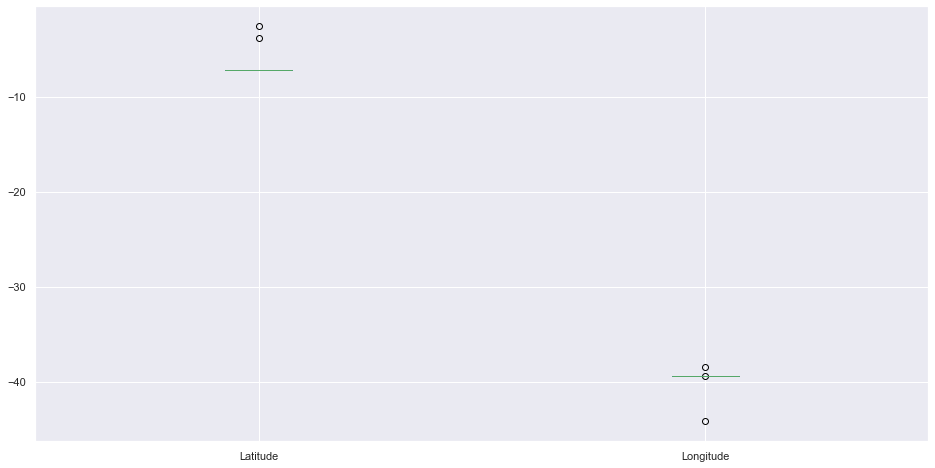

In [43]:
df.boxplot(column = ['Latitude', 'Longitude'])

Como é de se esperar os pontos turísticos de uma mesma cidade terão uma pequena variação entre a latitude e longitude destes, resultando que pontos mais distantes serão identificados como outliers, contudo, eles podem de fato serem um ponto turístico ou simplesmente, terem sido erroneamente geocodificados (Por exemplo: Um ponto do Crato, CE, ser codificado para um lugar no Maranhão). 

A decisão tomada quanto a isso será limitar as latitudes e longitudes em um intervalo, pré-definido, tendo em consideração os seguintes valores para a latitude e longitude das cidades (Obtidos por meio de uma pesquisa no Google):

- Crato: 7.2300° S, 39.4123° W
- São Paulo: 23.5505° S, 46.6333° W
- João Pessoa: 7.1195° S, 34.8450° W
- Varginha: 21.5561° S, 45.4369° W
- Uberlândia: 18.9128° S, 48.2755° W
- Hallstatt, Aústria: 47.5622° N, 13.6493° E


In [44]:
def dropOutliersByZScore(df, column, threshold = 3):

    df2 = df[(np.abs(stats.zscore(df[column])) < threshold)].copy()

    df2.reset_index(inplace = True)
    df2.drop(columns = ['index'], inplace = True)
    
    return df2

def dropOutliersByRange(df, column, minValue, maxValue):

    df2 = df[abs(df[column]) > maxValue].copy()
    df2.reset_index(inplace = True)
    df2.drop(columns = ['index'], inplace = True)
    
    df3 = df2[abs(df2[column]) < minValue].copy()
    df3.reset_index(inplace = True)
    
    df3.drop(columns = ['index'], inplace = True)
    
    return df3

Temos que:

Latitude: 1 deg = 110,574 km

Longitude: 1 deg = 111,320 * cos(latitude) km

Serão aceitos pontos que se encontrem a até 1 grau em termos absolutos da mediana.

In [45]:
df = dropOutliersByRange(df, 'Latitude', abs(df['Latitude'].median() - 1), abs(df['Latitude'].median() + 1))
df = dropOutliersByRange(df, 'Longitude', abs(df['Longitude'].median() - 1), abs(df['Longitude'].median() + 1))
print("Sobraram", len(df), "instâncias!")

Sobraram 9 instâncias!


## Obter matriz de distâncias

In [46]:
df.reset_index(inplace = True) # adicionar uma coluna de indices

In [47]:
def createDistancesMatrix(lat, lon):
    if len(lat) != len(lon):
        return None
    
    dimension = len(lat)
    matrix = np.zeros((dimension, dimension))

    RRR = 6378.388
    for i in range(dimension):
        for j in range(dimension):
            dlon = math.radians(lon[j]) - math.radians(lon[i])
            dlat = math.radians(lat[j]) - math.radians(lat[i])

            a = math.sin(dlat / 2) ** 2 + math.cos(math.radians(lat[i])) * math.cos(math.radians(lat[j])) * math.sin(dlon / 2) ** 2
            c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
            
            matrix[i][j] = RRR * c
    
    return matrix

In [49]:
matrix = createDistancesMatrix(df['Latitude'], df['Longitude'])

In [50]:
def scatter(x, y, title = None):
    fig, ax = plt.subplots()
    ax.scatter(x, y, c='orange')
    #line = mlines.Line2D([0, 1], [0, 1], color='black')
    #transform = ax.transAxes
    #line.set_transform(transform)
    #ax.add_line(line)
    plt.xlabel("Lat")
    plt.ylabel("Lon")
    if title != None:
        plt.title(title)
    plt.show()

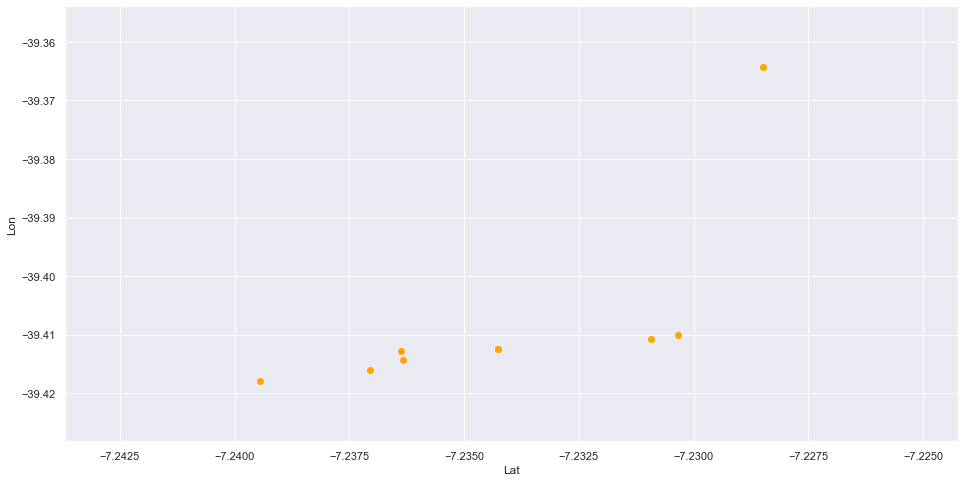

In [53]:
scatter(df['Latitude'], df['Longitude'])

## Função fitness
Será o inverso da distância da rota.

In [54]:
def getDistance(route, matrix):
    distance = 0
    for i in range(0, len(route) - 1):
        distance += matrix[route[i]][route[i + 1]]
        
    distance += matrix[route[len(route) - 1]][route[0]]
    
    return distance

def getFitness(cost):
    if cost != 0:
        return 1 / cost
    else:
        return 1

## Criação de rotas
Geração aleatória.

In [55]:
def createRoute():
    return random.sample(list(df['index']), len(df))

## População inicial
Tudo se iniciou com um clique do mouse.

In [56]:
def createPopulation(size):
    population = []
    
    for i in range(size):
        route_id = i
        newRoute = createRoute()
        distance = getDistance(newRoute, matrix)
        fitness = getFitness(distance)
        
        population.append({"ID": route_id, "Route": newRoute, "Distance": distance, "Fitness": fitness})
    
    return population

## Classificando os indivíduos
Só os mais fortes sobrevivem

In [57]:
def rank(population):
    return sorted(population, key = lambda x : x['Fitness'], reverse = True)

## Seleção dos pais
Só os mais fortes sobrevivem.

In [58]:
def selection(population, eliteSize):
    selected = []
    
    candidates = pd.DataFrame([list(map(pop.get, ['ID', 'Fitness'])) for pop in population], columns = ['ID', 'Fitness'])
    candidates['cum_sum'] = candidates['Fitness'].cumsum()
    ## calcular o fitness relativo de cada individuo
    candidates['cum_pct'] = 100 * candidates['cum_sum'] / candidates['Fitness'].sum()
    
    for i in range(eliteSize): # Elitismo
        selected.append(population[i])
        
    for i in range(len(population) - eliteSize):
        pick = 100 * random.random()
        for i in range(len(population)):
            if pick <= candidates.iat[i, 3]:
                selected.append(population[i])
                break
                
    return selected

## Cruzamento
Geração de novos indivíduos a partir do cruzamento.

In [59]:
def breed(a, b):
    childA = []
    childB = []
    
    geneA = int(random.random() * len(a))
    geneB = int(random.random() * len(b))
    
    start = min(geneA, geneB)
    end = max(geneA, geneB)
    
    for i in range(start, end):
        childA.append(a[i])
        
    childB = [point for point in b if point not in childA]
    
    return (childA + childB)

In [60]:
def createOffspring(population, eliteSize):
    childs = []
    pool = random.sample(population, len(population))
    
    for i in range(eliteSize):
        childs.append(pool[i])
        
    for i in range(0, len(population) - eliteSize):
        route_id = len(childs)
        newRoute = breed(pool[i]['Route'], pool[len(population) - i - 1]['Route'])
        distance = getDistance(newRoute, matrix)
        fitness = getFitness(distance)
        childs.append({"ID": route_id, "Route": newRoute, "Distance": distance, "Fitness": fitness})
        
    return childs

## Mutação
Troca a ordem de visitação de dois pontos.

In [61]:
def mutation(route, rate):
    for swapped in range(len(route)):
        if(random.random() < rate):
            toSwap = int(random.random() * len(route))
            
            aux = route[toSwap]
            route[toSwap] = route[swapped]
            route[swapped] = aux
            
    return route

In [62]:
def mutatePopulation(population, rate):
    mutated = []
    
    for i in range(len(population)):
        route_id = len(mutated)
        newRoute = mutation(population[i]['Route'], rate)
        distance = getDistance(newRoute, matrix)
        fitness = getFitness(distance)
        mutated.append({"ID": route_id, "Route": newRoute, "Distance": distance, "Fitness": fitness})
        
    return mutated

## Próxima geração

In [63]:
def nextGeneration(currentGeneration, eliteSize, mutationRate):
    ranked = rank(currentGeneration)
    selected = selection(ranked, eliteSize)
    child = createOffspring(selected, eliteSize)
    
    return mutatePopulation(child, mutationRate)

## Juntando tudo e executando

In [64]:
def geneticAlgorithm(popSize, eliteSize, mutationRate, generations, showResults = False):
    pops = createPopulation(popSize)
    results = []
    
    if showResults is True:
        best = rank(pops)[0]['Distance']
        print("Initial distance: " + str(best))
        results.append({"Generation": 0, "Distance": best})
        
    for i in range(generations):
        pops = nextGeneration(pops, eliteSize, mutationRate)
        if showResults is True:
            best = rank(pops)[0]['Distance']
            results.append({"Generation": i + 1, "Distance": best})
            
    if showResults is True:
        best = rank(pops)[0]['Distance']
        print("Final distance: " + str(best))
        results.append({"Generation": generations + 1, "Distance": best})
        
    return (rank(pops), results)

Executando com um tamanho de população igual a 100, elitismo igual a 25, chance de mutação igual a 0,01% e 500 gerações.

Initial distance: 13.341578516858206
Final distance: 12.535341036586251


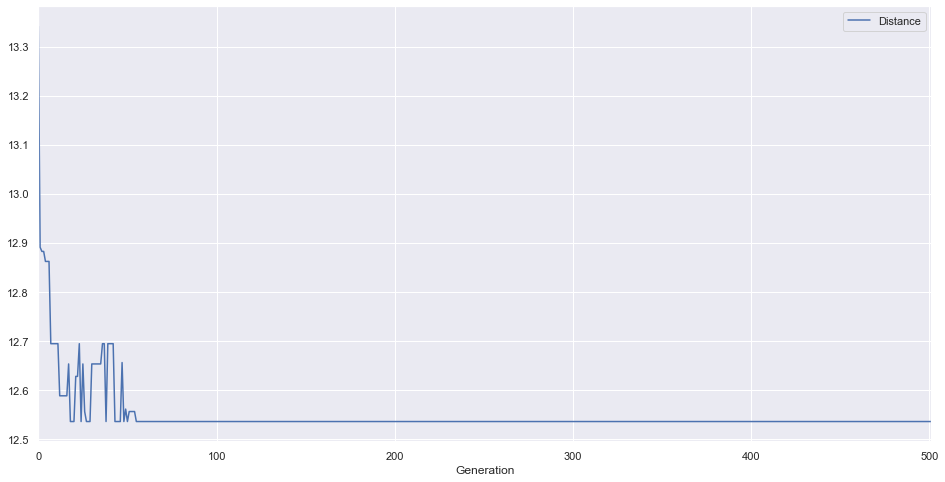

In [65]:
f, results = geneticAlgorithm(100, 25, 0.0001, 500, showResults = True)
pd.DataFrame(results).plot.line(x = "Generation",
                                y = "Distance")

Initial distance: 12.811553488646835
Final distance: 12.866040457896691


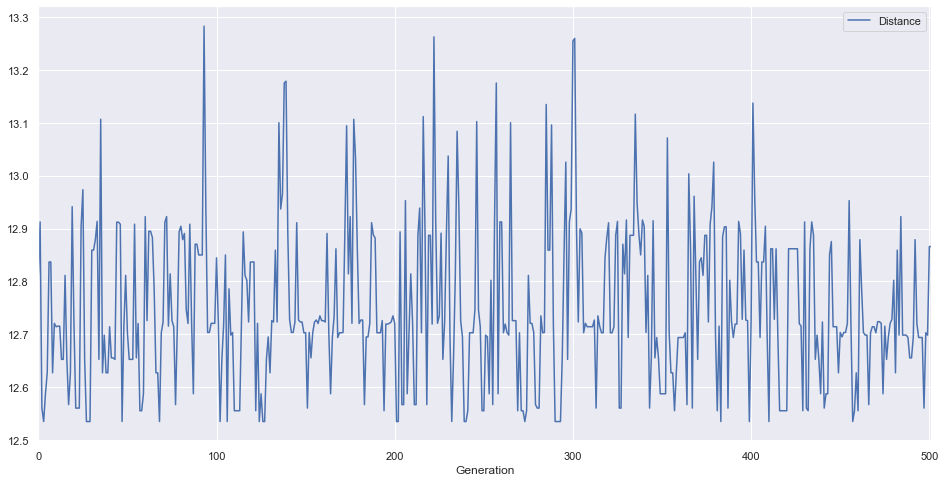

In [66]:
f, results = geneticAlgorithm(100, 25, 0.1, 500, showResults = True)
pd.DataFrame(results).plot.line(x = "Generation",
                                y = "Distance")

Initial distance: 12.88223220624932
Final distance: 12.535341036586253


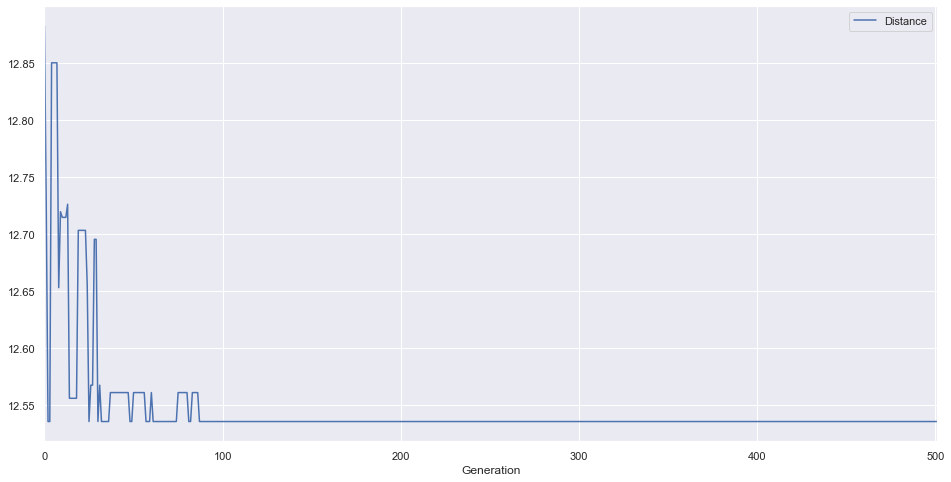

In [67]:
f, results = geneticAlgorithm(100, 50, 0.0001, 500, showResults = True)
pd.DataFrame(results).plot.line(x = "Generation",
                                y = "Distance")